#  Spam classification with Naive Bayes


- Libraries
- Exploring the Dataset
- Distribution spam and non-spam plots
- Text Analytics
- Feature Engineering
- Predictive analysis (**Multinomial Naive Bayes and and Gausian Naive Bayes**)
- Conclusion


## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import io
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline  

## Exploring the Dataset

## For this project we are going to use three datasets and combine them together. 

1. Spam email dataset
2. Ham dataset
3. Sms collection dataset.

for the first two datasets, we have to merge the files and manually create the classes and for the third dataset, the Spam-Ham classes are predefined.

In [2]:
# Let's read the email dataset

class FormEmailDataset:
    def __init__(self, path_of_email):
        self.path_of_email = path_of_email
        
    def reading_files(self,path):
        for root, dirnames, filenames in os.walk(path):
            for filename in filenames:
                
                path = os.path.join(root, filename)
                if filename.endswith('.html'):
                    print(path)

                inBody = False
                lines = []
                f = io.open(path, 'r', encoding='latin1')
                for line in f:
                    if inBody:
                        lines.append(line)
                    elif line == '\n':
                        inBody = True
                f.close()
                message = '\n'.join(lines)
                yield path, message
            
    def form_dataframe(self,path, classification): #dataframefromdirectory
        rows = []
        index = []
        for filename, message in self.reading_files(r'{}'.format(path)):
            rows.append({'message': message, 'class': classification})
            index.append(filename)

        return pd.DataFrame(rows, index=index)
    
    def get_data(self):   

        formed_data = pd.DataFrame({'message': [], 'class': []})
        for path_name in os.listdir(self.path_of_email):
            path_of_files = os.path.join(self.path_of_email, path_name)

            formed_data = pd.concat([formed_data, self.form_dataframe(path_of_files, path_name)])
            print(f"{path_name} data we got")
            
        return formed_data
            

In [3]:
ls

 EDA_final.ipynb   emails.csv              sms.csv
 EDA.ipynb        'Model Training.ipynb'   spamham.csv


In [4]:
email_dataset = pd.read_csv('emails.csv')

In [5]:
email_dataset

,Unnamed: 0,Label,Message,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\nthe transport v...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\nhpl ...,0
5168,2933,ham,Subject: calpine daily gas nomination\n>\n>\nj...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [6]:
email_dataset = email_dataset.reset_index(drop=True)
email_dataset.head()

,Unnamed: 0,Label,Message,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [7]:
#let's read the sms data
sms_data = pd.read_csv('https://raw.githubusercontent.com/bigmlcom/python/master/data/spam.csv', sep = '\t')
sms_data.columns = ['class','message']
sms_data = sms_data[['message', 'class']]
sms_data.head()

,message,class
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


## Let's merge them together

In [8]:
data = pd.concat([email_dataset, sms_data])
print("first five data are:\n","=>"*10)
print(data.head(5))

print("last five data are:\n","=>"*10)
print(data.tail(5))

first five data are:
 =>=>=>=>=>=>=>=>=>=>
   Unnamed: 0 Label                                            Message  \
0       605.0   ham  Subject: enron methanol ; meter # : 988291\nth...   
1      2349.0   ham  Subject: hpl nom for january 9 , 2001\n( see a...   
2      3624.0   ham  Subject: neon retreat\nho ho ho , we ' re arou...   
3      4685.0  spam  Subject: photoshop , windows , office . cheap ...   
4      2030.0   ham  Subject: re : indian springs\nthis deal is to ...   

   label_num message class  
0        0.0     NaN   NaN  
1        0.0     NaN   NaN  
2        0.0     NaN   NaN  
3        1.0     NaN   NaN  
4        0.0     NaN   NaN  
last five data are:
 =>=>=>=>=>=>=>=>=>=>
     Unnamed: 0 Label Message  label_num  \
651         NaN   NaN     NaN        NaN   
652         NaN   NaN     NaN        NaN   
653         NaN   NaN     NaN        NaN   
654         NaN   NaN     NaN        NaN   
655         NaN   NaN     NaN        NaN   

                               

## Shape of the data

In [9]:
data.shape

(5827, 6)

## Check null values

In [10]:
data.isna().sum()

Unnamed: 0     656
Label          656
Message        656
label_num      656
message       5171
class         5171
dtype: int64

### We can see that there is no null values in this dataset.



## Let's check for duplicate values

In [11]:
print(f"we have {data.duplicated().sum()} duplicate values found in the dataset. \nBelow are the duplicate data. \n", "=="*20)
data[data.duplicated()]

we have 9 duplicate values found in the dataset. 
Below are the duplicate data. 


,Unnamed: 0,Label,Message,label_num,message,class
340,NaN,NaN,NaN,NaN,1) Go to write msg 2) Put on Dictionary mode 3...,ham
400,NaN,NaN,NaN,NaN,"Sorry, I'll call later",ham
466,NaN,NaN,NaN,NaN,I cant pick the phone right now. Pls send a me...,ham
477,NaN,NaN,NaN,NaN,I'm at work. Please call,ham
514,NaN,NaN,NaN,NaN,"Sorry, I'll call later",ham
549,NaN,NaN,NaN,NaN,"Sorry, I'll call later",ham
560,NaN,NaN,NaN,NaN,Ok lor.,ham
581,NaN,NaN,NaN,NaN,K. I will sent it again,ham
649,NaN,NaN,NaN,NaN,"Sorry, I'll call later",ham


**As we can see there are some duplicate values. Let's remove keep the first ones.**

In [12]:
data = data.drop_duplicates(keep='first')
data = data.reset_index(drop=True)
data.shape

(5818, 6)

**So we have removed the values which are found duplicated with some other values**

We have now 3590 rows data.

In [13]:
#let's save the dataset
data.to_csv("spamham.csv", index=False)

In [14]:
data.isnull().sum()

Unnamed: 0     647
Label          647
Message        647
label_num      647
message       5171
class         5171
dtype: int64

In [15]:
data.dropna

<bound method DataFrame.dropna of       Unnamed: 0 Label                                            Message  \
0          605.0   ham  Subject: enron methanol ; meter # : 988291\nth...   
1         2349.0   ham  Subject: hpl nom for january 9 , 2001\n( see a...   
2         3624.0   ham  Subject: neon retreat\nho ho ho , we ' re arou...   
3         4685.0  spam  Subject: photoshop , windows , office . cheap ...   
4         2030.0   ham  Subject: re : indian springs\nthis deal is to ...   
...          ...   ...                                                ...   
5813         NaN   NaN                                                NaN   
5814         NaN   NaN                                                NaN   
5815         NaN   NaN                                                NaN   
5816         NaN   NaN                                                NaN   
5817         NaN   NaN                                                NaN   

      label_num                          

In [16]:
data.shape

(5818, 6)

## Distribution spam/non-spam plots

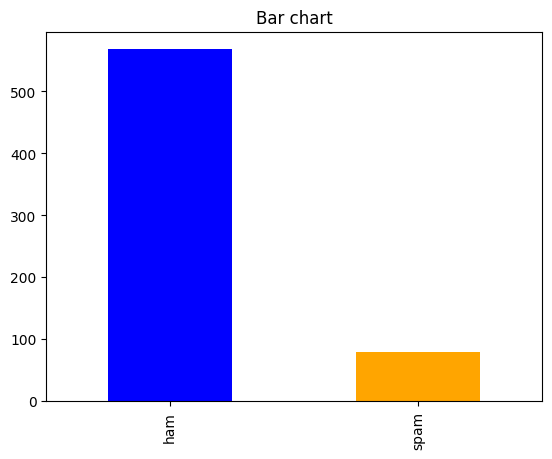

In [17]:
count_Class=pd.value_counts(data["class"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

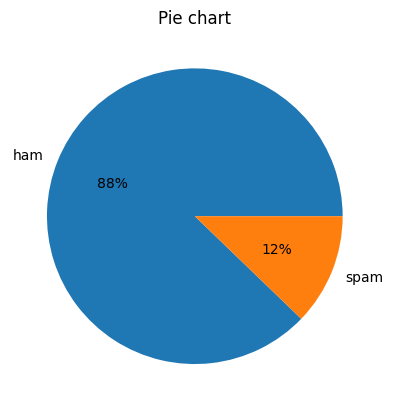

In [18]:
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

## Text Analytics

We want to find the frequencies of words in the spam and non-spam messages. The words of the messages will be model features.<p>
We use the function Counter.

In [19]:
count1 = Counter(" ".join(data[data['class']=='ham']["message"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(data[data['class']=='spam']["message"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

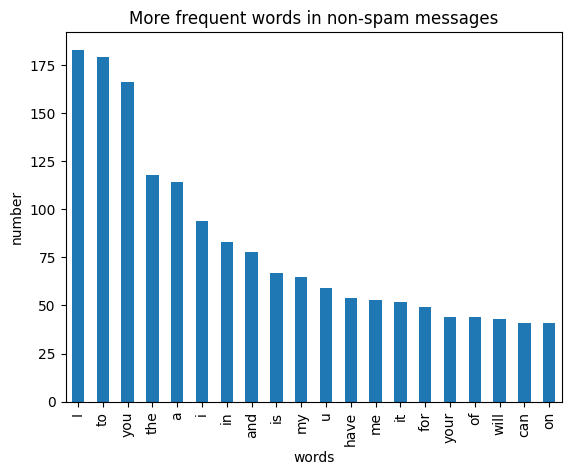

In [20]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

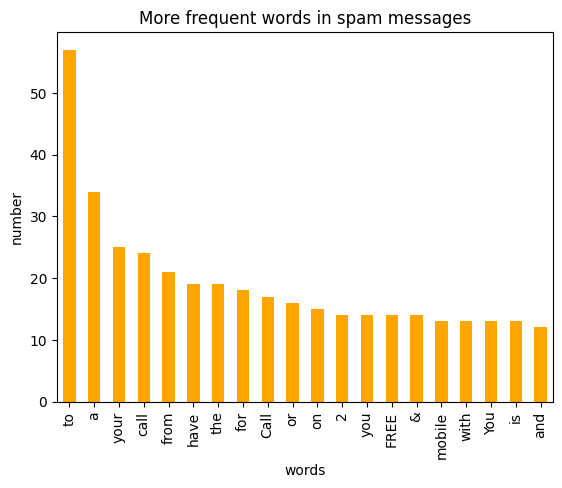

In [21]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

We can see that the majority of frequent words in both classes are stop words such as 'to', 'a', 'or' and so on. <p>
With stop words we refer to the most common words in a lenguage, there is no simgle, universal list of stop words. <p>

## Feature engineering

Text preprocessing, tokenizing and filtering of stopwords are included in a high level component that is able to build a dictionary of features and transform documents to feature vectors.<p>
**We remove the stop words in order to improve the analytics**

In [22]:
data.drop('Unnamed: 0',axis=1,inplace=True)
data.drop('label_num',axis=1,inplace=True)
data.drop('message',axis=1,inplace=True)
data.drop('class',axis=1,inplace=True)


In [23]:
data.head()


,Label,Message
0,ham,Subject: enron methanol ; meter # : 988291\nth...
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a..."
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\nthis deal is to ...


In [24]:
data.isnull().sum()

Label      647
Message    647
dtype: int64

In [25]:
data = data.dropna(subset=["Label"])

In [26]:
data["Message"] = data["Message"].fillna("")

In [27]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(data["Message"])
np.shape(X)

(5171, 50140)

We have created more than 63395 new features. The new feature $j$ in the row $i$ is equal to 1 if the word $w_{j}$ appears in the text example $i$. It is zero if not.

## Predictive Analysis

**My goal is to predict if a new sms is spam or non-spam. I assume that is much worse misclassify non-spam than misclassify an spam. (I don't want to have false positives)**
<p>
The reason is because I normally don't check the spam messages.<p> The two possible situations are:<p>
1. New spam sms in my inbox. (False negative).<p>
OUTCOME: I delete it.<p>
2. New non-spam sms in my spam folder (False positive).<p>  OUTCOME: I probably don't read it. <p>
I prefer the first option!!!

First we transform the variable spam/non-spam into binary variable, then we split our data set in training set and test set. 

In [29]:
#let's map the values of target column ( class )
data["Label"]=data["Label"].map({'spam':1,'ham':0})


In [31]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['Label'], test_size=0.33, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(3464, 50140), (1707, 50140)]


### Multinomial naive bayes classifier

We train different bayes models changing the regularization parameter $\alpha$. <p>
We evaluate the accuracy, recall and precision of the model with the test set.

In [32]:
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1 

Let's see the first 10 learning models and their metrics!

In [33]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.992783,0.980668,0.973970,0.955319
1,0.11001,0.991051,0.976567,0.971800,0.943158
2,0.22001,0.991051,0.977153,0.971800,0.945148
3,0.33001,0.990185,0.976567,0.969631,0.945032
4,0.44001,0.989319,0.975395,0.967462,0.942918
5,0.55001,0.989030,0.975981,0.967462,0.944915
6,0.66001,0.988453,0.976567,0.967462,0.946921
7,0.77001,0.988164,0.977153,0.967462,0.948936
8,0.88001,0.987587,0.977153,0.967462,0.948936
9,0.99001,0.987009,0.976567,0.965293,0.948827


let's select the model with the most test precision

In [34]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             13.420010
Train Accuracy     0.950924
Test Accuracy      0.942004
Test Recall        0.791757
Test Precision     0.991848
Name: 122, dtype: float64

**The best model does not produce any false positive, which is our goal.** <p>
Let's see if there is more than one model with 100% precision !

In [35]:
models['Test Precision'].max()

0.9918478260869565

In [36]:
models[models['Test Precision'] == models['Test Precision'].max()].head(n=5)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
122,13.42001,0.950924,0.942004,0.791757,0.991848


Between these models with the highest possible precision, we are going to select which has more test accuracy.

In [37]:
best_index = models[models['Test Precision']==models['Test Precision'].max()]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, y_train)
models.iloc[best_index, :]

alpha             13.420010
Train Accuracy     0.950924
Test Accuracy      0.942004
Test Recall        0.791757
Test Precision     0.991848
Name: 122, dtype: float64

#### Confusion matrix with naive bayes classifier

In [38]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1243,3
Actual 1,96,365


* #### We misclassify 57 spam messages as non-spam emails whereas we don't misclassify any non-spam message.